# COMP30760 Assignment 1 - Task 2

In this notebook I used all the JSON files collected in the first task to perform the analysis between the albums.

In [482]:
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
!pip install lyricsgenius
import lyricsgenius
from collections import Counter
import re
%matplotlib inline

In [1028]:

# Precision that we'll use for Pandas display
pd.set_option('precision', 2)
#artists names
artist_names = ["Drake", "Kanye West"]

#album names 
albums = {"Drake":"CLB", "Kanye West":"Donda"}

#list of all songs (CLB and Donda)
all_Songs = ["Champagne poetry", "Papi's home" , "Girls Want Girls", "In The Bible", "Love All", "Fair Trade", "Way 2 Sexy", "TSU", "N 2 Deep", "Pipe Down", "No Friends In The Industry", "Knife Talk", "7am On Bridle Path", "Race My Mind", "Fountains", "Get Along Better", "You Only Live Twice", "IMY2", "Fucking Fans", "The Remorse","Donda Chant", "Jail", "God Breathed", "Off the Grid", "Praise God", "Jonah", "Ok Ok", "Junya", "Believe What I Say", "24", "Remote Control", "Moon", "Heaven and Hell", "Donda", "Keep My Spririt Alive", "Jesus Lord", "New Again", "Tell The Vision", "Lord I Need You", "Pure Souls", "Come To Life", "No Child Left Behind", "Jail pt 2", "Ok Ok pt 2", "Junya pt 2", "Jesus Lord pt 2"]

#songs in CLB by Drake
CLB_Songs = ["Champagne poetry", "Papi's home" , "Girls Want Girls", "In The Bible", "Love All", "Fair Trade", "Way 2 Sexy", "TSU", "N 2 Deep", "Pipe Down", "No Friends In The Industry", "Knife Talk", "7am On Bridle Path", "Race My Mind", "Fountains", "Get Along Better", "You Only Live Twice", "IMY2", "Fucking Fans", "The Remorse",] 

#songs in Donda by Kanye West
Donda_Songs = ["Donda Chant", "Jail", "God Breathed", "Off the Grid", "Praise God", "Jonah", "Ok Ok", "Junya", "Believe What I Say", "24", "Remote Control", "Moon", "Heaven and Hell", "Donda", "Keep My Spririt Alive", "Jesus Lord", "New Again", "Tell The Vision", "Lord I Need You", "Pure Souls", "Come To Life", "No Child Left Behind", "Jail pt 2", "Ok Ok pt 2", "Junya pt 2", "Jesus Lord pt 2"]

# Default font size
fontsize = 13

In [1029]:
# directory for raw data storage
dir_raw = Path("/Users/sagarmahajan/raw")
# directory for song lyrics
dir_raw_lyrics = Path("/Users/sagarmahajan/raw/lyrics")
#directory for storing clean pre-processed data
dir_data = Path("/Users/sagarmahajan/data")
# make sure it exists
dir_data.mkdir(parents=True, exist_ok=True)

## Data Processing
Before we can analyse the data, we need to transform it into a usable format.

firstly I looked for all the raw JSON song files.

In [948]:
song_files = {}
lyrics_files = {}
for song in all_Songs:
    song_files[song] = []
for fpath in dir_raw.iterdir():
    if fpath.suffix == ".json":
        # parse the filename
        parts = fpath.stem.split("-")
        if parts[0] in all_Songs:
            song_files[parts[0]].append(fpath)
for song in all_Songs:
    print("%s: Found %d raw data files" % (song, len(song_files[song])))



Champagne poetry: Found 32 raw data files
Papi's home: Found 32 raw data files
Girls Want Girls: Found 32 raw data files
In The Bible: Found 32 raw data files
Love All: Found 32 raw data files
Fair Trade: Found 32 raw data files
Way 2 Sexy: Found 32 raw data files
TSU: Found 32 raw data files
N 2 Deep: Found 32 raw data files
Pipe Down: Found 32 raw data files
No Friends In The Industry: Found 32 raw data files
Knife Talk: Found 32 raw data files
7am On Bridle Path: Found 32 raw data files
Race My Mind: Found 32 raw data files
Fountains: Found 32 raw data files
Get Along Better: Found 32 raw data files
You Only Live Twice: Found 32 raw data files
IMY2: Found 32 raw data files
Fucking Fans: Found 32 raw data files
The Remorse: Found 32 raw data files
Donda Chant: Found 32 raw data files
Jail: Found 32 raw data files
God Breathed: Found 32 raw data files
Off the Grid: Found 32 raw data files
Praise God: Found 32 raw data files
Jonah: Found 32 raw data files
Ok Ok: Found 32 raw data files

Then I looked for for lyrics files and stored their path

In [949]:
lyrics_files = {}
for song in all_Songs:
    lyrics_files[song] = []
for fpath in dir_raw_lyrics.iterdir():
    if fpath.suffix == ".txt":
        # parse the filename
        parts = fpath.stem.split("-")
        if parts[0] in all_Songs:
            lyrics_files[parts[0]] = str(fpath)
for song in all_Songs:
    print("%s: Found %s raw data files" % (song, lyrics_files[song]))



Champagne poetry: Found /Users/sagarmahajan/raw/lyrics/Champagne poetry.txt raw data files
Papi's home: Found /Users/sagarmahajan/raw/lyrics/Papi's home.txt raw data files
Girls Want Girls: Found /Users/sagarmahajan/raw/lyrics/Girls Want Girls.txt raw data files
In The Bible: Found /Users/sagarmahajan/raw/lyrics/In The Bible.txt raw data files
Love All: Found /Users/sagarmahajan/raw/lyrics/Love All.txt raw data files
Fair Trade: Found /Users/sagarmahajan/raw/lyrics/Fair Trade.txt raw data files
Way 2 Sexy: Found /Users/sagarmahajan/raw/lyrics/Way 2 Sexy.txt raw data files
TSU: Found /Users/sagarmahajan/raw/lyrics/TSU.txt raw data files
N 2 Deep: Found /Users/sagarmahajan/raw/lyrics/N 2 Deep.txt raw data files
Pipe Down: Found /Users/sagarmahajan/raw/lyrics/Pipe Down.txt raw data files
No Friends In The Industry: Found /Users/sagarmahajan/raw/lyrics/No Friends In The Industry.txt raw data files
Knife Talk: Found /Users/sagarmahajan/raw/lyrics/Knife Talk.txt raw data files
7am On Bridle 

Defined a function to split the song text files into words.

In [816]:
def split_into_words(any_chunk_of_text):
    lowercase_text = any_chunk_of_text.lower()
    split_words = re.split("\W+", lowercase_text)
    return split_words 

In [817]:
df_song_wordCount = {}#holds the wordcount of each song 
for song in all_Songs:
    #opening and reading the file
    data = open(lyrics_files[song], encoding="latin1").read()
    all_the_words = split_into_words(data)
    df_song_wordCount[song] = len(all_the_words)

### Data Parsing and Merging
define functions that will parse an individual raw JSON data file coming from the Genius API.

In [1032]:
def parse_raw_data(song, fpath):
    fin = open(fpath, "r")
    jdata = fin.read()
    data = json.loads(jdata)
    key = 0
    rows = []

    row = {"Song": song}
    
    row["Key"] = key 
    #add artists name
    row["artist_name"] = data['result']['primary_artist']['name']
    #add page views of the song
    row["page_views"] = data['result']['stats']['pageviews']
    #add peyongs
    row["peyongs"] = data['result']['pyongs_count']
    #add annotations
    row["Annotations"] = data['result']['annotation_count']
    #if concurrents is not present, write 0
    if 'concurrents' not in data['result']['stats']:
        row["Concurrents"] = 0
    else:
         row["Concurrents"] = data['result']['stats']['concurrents']
    #add number of words in the song 
    row["word Count"] = df_song_wordCount[song]
    rows.append(row)
    fin.close()
    # return back the DataFrame
    return pd.DataFrame(rows)

this function will parse and merge a collection of raw data files:

In [1033]:
def parse_merge_raw_data(song, fpaths):
    df_files = []
#     key = 0
    # process each file for this city
    print("Reading and parsing %d JSON data files ..." % len(fpaths))
    for fpath in fpaths:
        # produce a DataFrame from this file
        df_file = parse_raw_data(song, fpath)
        df_files.append(df_file)
    # concatenate all the DataFrames together into a single frame
    df_album = pd.concat(df_files)
    # next we remove duplicate observations based on the page views field
    df_album.drop_duplicates(subset="page_views", keep="first", inplace=True)
    #sorted values according to the page views, 
    df = df_album.sort_values(by = 'page_views') 
    # now set the index column to be the Key, a unique numbet to keep a count
    df["Key"] = range(1, 1+len(df))
    #set key as the index
    df.set_index("Key", inplace=True)
    # we will also sort the frame by its index
    return df

Parsed and merged the raw data files for each song, producing a single merged Pandas Data Frames for each song which we can analyse later on:

In [1034]:
df_albums = {}

for song in all_Songs:
    print("-- %s" % song)
    df_album = parse_merge_raw_data(song, song_files[song])
    df_albums[song] = df_album

-- Champagne poetry
Reading and parsing 32 JSON data files ...
-- Papi's home
Reading and parsing 32 JSON data files ...
-- Girls Want Girls
Reading and parsing 32 JSON data files ...
-- In The Bible
Reading and parsing 32 JSON data files ...
-- Love All
Reading and parsing 32 JSON data files ...
-- Fair Trade
Reading and parsing 32 JSON data files ...
-- Way 2 Sexy
Reading and parsing 32 JSON data files ...
-- TSU
Reading and parsing 32 JSON data files ...
-- N 2 Deep
Reading and parsing 32 JSON data files ...
-- Pipe Down
Reading and parsing 32 JSON data files ...
-- No Friends In The Industry
Reading and parsing 32 JSON data files ...
-- Knife Talk
Reading and parsing 32 JSON data files ...
-- 7am On Bridle Path
Reading and parsing 32 JSON data files ...
-- Race My Mind
Reading and parsing 32 JSON data files ...
-- Fountains
Reading and parsing 32 JSON data files ...
-- Get Along Better
Reading and parsing 32 JSON data files ...
-- You Only Live Twice
Reading and parsing 32 JSON dat

below I check if there are any missing values in the data frames:

In [1036]:
for song in all_Songs:
    print("-- %s" % song)
    missing_counts = df_albums[song].isnull().sum()
    # which coludmns have missing values?
    missing_counts = missing_counts[missing_counts>0]
    if len(missing_counts) == 0:
        print("No missing values found")
    else:
        print(missing_counts)

-- Champagne poetry
No missing values found
-- Papi's home
No missing values found
-- Girls Want Girls
No missing values found
-- In The Bible
No missing values found
-- Love All
No missing values found
-- Fair Trade
No missing values found
-- Way 2 Sexy
No missing values found
-- TSU
No missing values found
-- N 2 Deep
No missing values found
-- Pipe Down
No missing values found
-- No Friends In The Industry
No missing values found
-- Knife Talk
No missing values found
-- 7am On Bridle Path
No missing values found
-- Race My Mind
No missing values found
-- Fountains
No missing values found
-- Get Along Better
No missing values found
-- You Only Live Twice
No missing values found
-- IMY2
No missing values found
-- Fucking Fans
No missing values found
-- The Remorse
No missing values found
-- Donda Chant
No missing values found
-- Jail
No missing values found
-- God Breathed
No missing values found
-- Off the Grid
No missing values found
-- Praise God
No missing values found
-- Jonah
No

## Data Analysis

now I will analyse the data colected about both the albums.

### Page Views

first we will look at the page views of the songs. this is the total number of views the song lyrics page has on the genius website. 

I plotted each songs page views in an album below over the data collection time. however becouse there are so many songs it is hard to interpret.

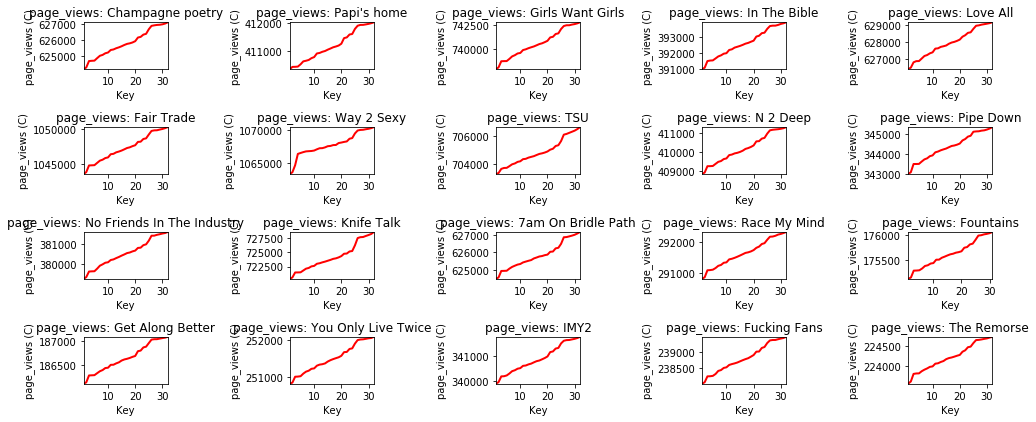

In [1037]:
fig = plt.figure(figsize=(14,7))
for i, song in enumerate(CLB_Songs):
    axc = fig.add_subplot(5, 5, i+1)
    ax = df_albums[song]["page_views"].plot(ax=axc, legend=False, lw=2, color="red")
    ax.set_title("page_views: %s" % song)
    ax.set_ylabel("page_views (C)")
    # note that we will use consistent Y-axis limits based on the ranges we computed above
    ax.set_ylim(df_albums[song]['page_views'].min()-2, df_albums[song]['page_views'].max()+2)
fig.tight_layout()

to get better results I decided to merge the page views songs according to the album they are in using the function below:

In [1038]:
def merge_data_by_column(col_name, album):
    columns = {}
    for song in album:
        columns[song] = df_albums[song][col_name]
    df_merged = pd.DataFrame(columns).sort_index()
    # note if we have some mismatches on dates between cities, we will drop the rows
    return df_merged.dropna()
    

In [1069]:
df_temp_merged_CLB = merge_data_by_column("page_views", CLB_Songs)
df_temp_merged_Donda = merge_data_by_column("page_views", Donda_Songs)

df_temp_merged_CLB.head()

,Champagne poetry,Papi's home,Girls Want Girls,In The Bible,Love All,Fair Trade,Way 2 Sexy,TSU,N 2 Deep,Pipe Down,No Friends In The Industry,Knife Talk,7am On Bridle Path,Race My Mind,Fountains,Get Along Better,You Only Live Twice,IMY2,Fucking Fans,The Remorse
Key,,,,,,,,,,,,,,,,,,,,
1,624184,410368,737864,390974,626428,1043561,1063360,703266,408844,342978,379262,720333,624509,290825,175130.0,186102,250821,339886,238012,223558
2,624296,410451,738066,391073,626522,1043846,1063642,703344,408927,343073,379352,720602,624594,290878,175157.0,186131,250852,339952,238060,223614
3,624689,410454,738707,391492,626831,1044788,1064686,703638,409256,343482,379626,721462,624958,291099,175294.0,186277,251010,340182,238242,223804
4,624705,410462,738720,391525,626899,1044808,1066370,703704,409259,343483,379636,721471,624963,291105,175296.0,186280,251014,340188,238246,223815
5,624714,410544,738725,391536,626903,1044827,1066512,703712,409269,343488,379641,721488,624970,291118,175301.0,186283,251024,340220,238258,223817


after merging it I summed up the page views of the songs in an album for all the times I collected the data. Then I plotted it to see the trent of the page views. Below is the graph for Donda:

     total page views Donda  total page views CLB
Key                                              
1                  14001768              9.78e+06
2                  14005036              9.78e+06
3                  14015576              9.79e+06
4                  14016081              9.79e+06
5                  14016951              9.79e+06
6                  14020591              9.79e+06
7                  14024835              9.80e+06
8                  14026604              9.80e+06
9                  14029722              9.80e+06
10                 14030771              9.80e+06
11                 14035656              9.80e+06
12                 14037551              9.81e+06
13                 14039342              9.81e+06
14                 14041033              9.81e+06
15                 14042902              9.81e+06
16                 14045102              9.81e+06
17                 14046651              9.81e+06
18                 14048814              9.81e+06


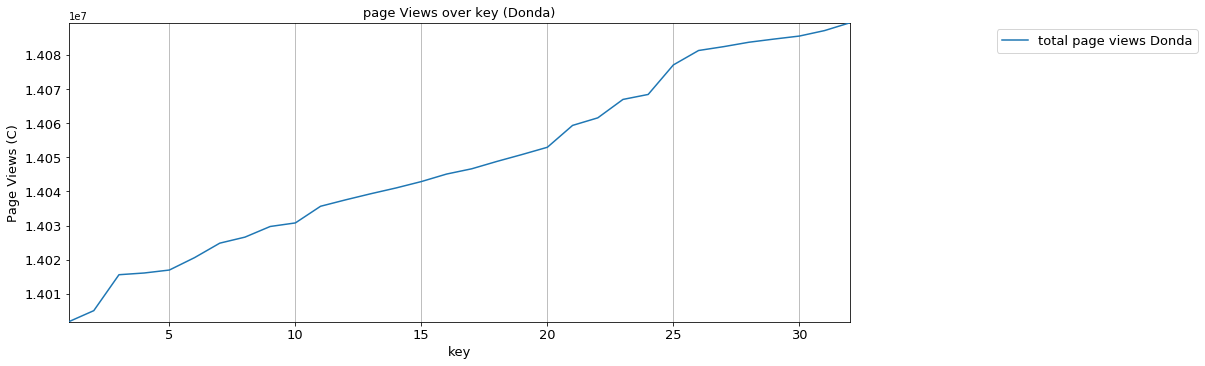

In [1042]:
sum_Donda = df_temp_merged_Donda.sum(axis = 1)
sum_CLB = df_temp_merged_CLB.sum(axis = 1)
df_sum_Donda = pd.DataFrame({"total page views Donda" : sum_Donda, "total page views CLB" : sum_CLB })
# print(df_sum_Donda)
ax = df_sum_Donda["total page views Donda"].plot(figsize=(14,5.5), fontsize=fontsize, zorder=3)
ax.set_title("page Views over key (Donda)", fontsize=fontsize)
ax.set_xlabel("key", fontsize=fontsize)
ax.set_ylabel("Page Views (C)", fontsize=fontsize)
# adjust the axis limits
ax.set_ylim(df_sum_Donda["total page views Donda"].min()-1, df_sum_Donda["total page views Donda"].max()+1)
ax.set_xlim(df_sum_Donda.index.min(), df_sum_Donda.index.max())

ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)

# add an x grid
ax.xaxis.grid(True);



And this is for CLB: 

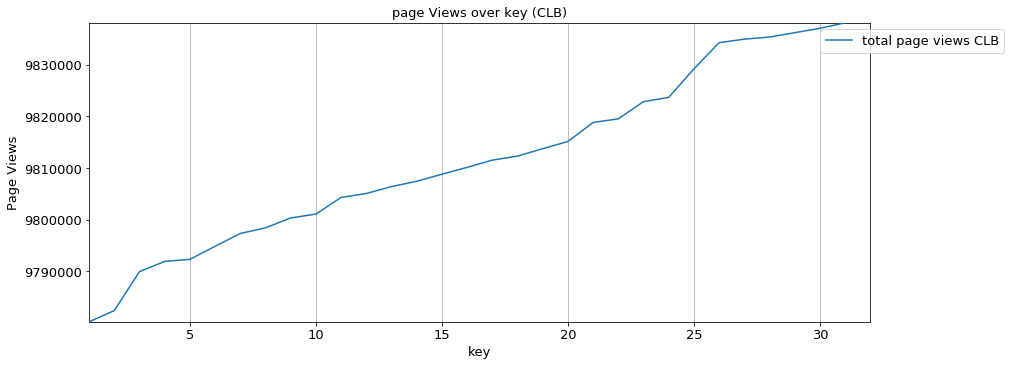

In [1045]:
ax = df_sum_Donda["total page views CLB"].plot(figsize=(14,5.5), fontsize=fontsize, zorder=3)
ax.set_title("page Views over key (CLB)", fontsize=fontsize)
ax.set_xlabel("key", fontsize=fontsize)
ax.set_ylabel("Page Views", fontsize=fontsize)
# adjust the axis limits
ax.set_ylim(df_sum_Donda["total page views CLB"].min()-1, df_sum_Donda["total page views CLB"].max()+1)
ax.set_xlim(df_sum_Donda.index.min(), df_sum_Donda.index.max())
ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)
# add an x grid
ax.xaxis.grid(True);

looking at both the graphs above, it is clear that both album's page views are in an increasing trend. they have a very similar graphs. at some points the graphs is more steeper than others, this can be because the data was collected in the morning and therefore there was more traffic on the website.

now to compare the page views even further, I will use Box plot. I took the maximum page view recorded for each song and seperated them according to their album. Then i used that data to make a box plot. Below is the box plot of Donda: 

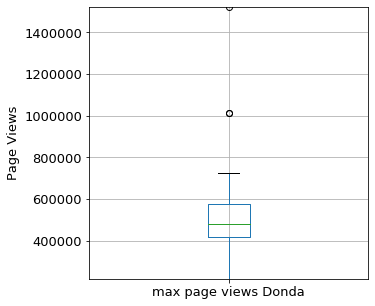

In [1056]:
temp_Donda = []
for song in Donda_Songs:
    temp_Donda.append(df_albums[song]["page_views"].max())

max_pageview_Donda = pd.DataFrame({"max page views Donda" : temp_Donda}, Donda_Songs)
# print(avg_peyongs_Donda)
ax = max_pageview_Donda.boxplot( column = "max page views Donda", figsize=(5,5), fontsize=fontsize)
ax.set_ylim(max_pageview_Donda["max page views Donda"].min()-100, max_pageview_Donda["max page views Donda"].max()+100)
ax.set_ylabel("Page Views", fontsize=fontsize);



and this is for CLB:

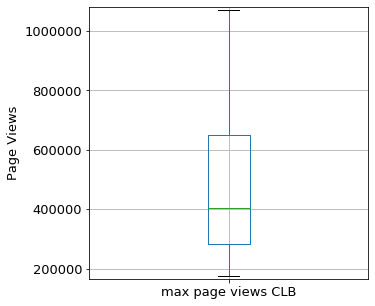

In [1057]:
temp_CLB = []
for song in CLB_Songs:
    temp_CLB.append(df_albums[song]["page_views"].max())

max_pageview_CLB = pd.DataFrame({"max page views CLB" : temp_CLB}, CLB_Songs)
# print(max_pageview_CLB)
ax = max_pageview_CLB.boxplot(column = "max page views CLB", figsize=(5,5), fontsize=fontsize)
ax.set_ylim(max_pageview_CLB["max page views CLB"].min()-10000, max_pageview_CLB["max page views CLB"].max()+10000)
ax.set_ylabel("Page Views", fontsize=fontsize);


comparing the box plot, we see that the median page views of Donda is higher that CLBs. this means Donda has better page views. moreover the boxplot for donda is very short, that means most of its song's page views are closer to the median than CLBs. Donda also has 2 outliers, which means these 2 songs have very high page views compared to the average.

to look at whoch song has the most views in each album I made a bar graph. Below is the bar graph for Donda:

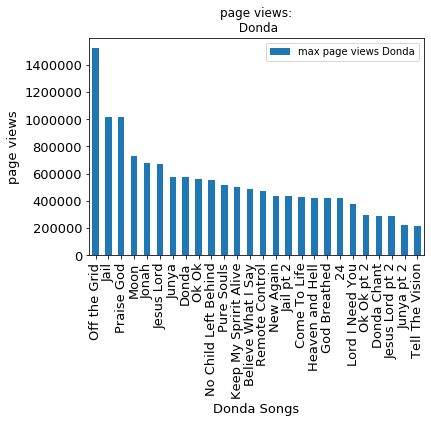

In [1080]:
ax = max_pageview_Donda.sort_values(by='max page views Donda', ascending = False).plot.bar( fontsize=fontsize , zorder=3,  title="page views:\n Donda")
ax.set_ylabel("page views", fontsize=fontsize);
ax.set_xlabel("Donda Songs", fontsize=fontsize);

And this is the bar graph for CLB:

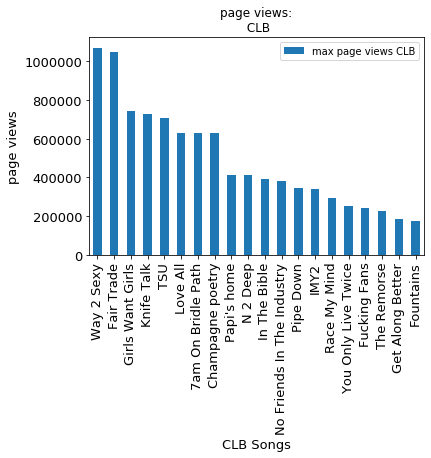

In [996]:
ax = max_pageview_CLB.sort_values(by='max page views CLB', ascending = False).plot.bar(fontsize=fontsize, zorder=3, title="page views:\n CLB")
ax.set_ylabel("page views", fontsize=fontsize);
ax.set_xlabel("CLB Songs", fontsize=fontsize);

in the bar graph for Donda, it is clearly visible the the "Off the gring" has the most viewed page. This was surely on of the outliers in the box plot. For CLB, "Way 2 Sexy" has the most viewed page.

### Lyrics
now we will look at the lyrics for all the songs. I decided to check what were the most used words in all the songs combines. 

first I listed out all the non meaningful words so that i can filter them out of the main analysis. 

In [1062]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
             'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
             'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
             'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
             'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
             'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
             'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
             'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
             'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
             'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
             'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
             'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 've', 'll', 'amp', 'm', 'mmh', '', 'get', 'got', 'oh', 'yeah' ]

this function below opens all the lyrics files and tallies the frequency of all the meaningful words.

In [1058]:
def get_most_frequent_words_directory(fPath):
    
    number_of_desired_words = 30
    meaningful_words_tally = Counter()
    
    for filepath in fPath.glob('*.txt'):   
        full_text = open(filepath, encoding="latin1").read()
        all_the_words = split_into_words(full_text)
        
        meaningful_words = [word for word in all_the_words if word not in stopwords]
        meaningful_words_tally.update(meaningful_words)
    
    most_frequent_meaningful_words = meaningful_words_tally.most_common(number_of_desired_words)

    return most_frequent_meaningful_words

In [1059]:
df_lyrics = {}
# for song in all_Songs:
get_most_frequent_words_directory(dir_raw_lyrics)
# print(lyrics_files)

[('yeah', 269),
 ('know', 267),
 ('like', 202),
 ('get', 155),
 ('got', 139),
 ('oh', 123),
 ('god', 122),
 ('west', 111),
 ('kanye', 107),
 ('woah', 101),
 ('lord', 98),
 ('see', 91),
 ('jesus', 89),
 ('love', 87),
 ('ain', 86),
 ('make', 86),
 ('let', 83),
 ('back', 81),
 ('tell', 76),
 ('shit', 76),
 ('uh', 75),
 ('donda', 73),
 ('okay', 72),
 ('come', 71),
 ('niggas', 71),
 ('chorus', 70),
 ('go', 69),
 ('one', 68),
 ('em', 66),
 ('life', 66)]

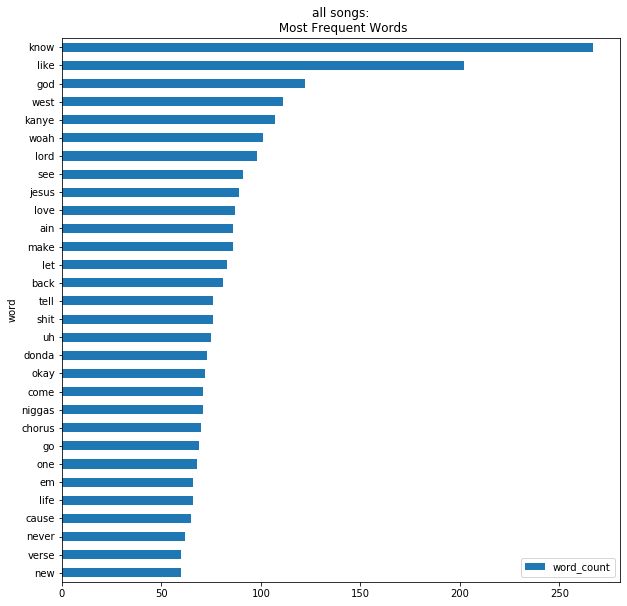

In [1063]:
frequencies = get_most_frequent_words_directory(dir_raw_lyrics)

#Make Counter dictionary into a Pandas DataFrame
word_frequency_df = pd.DataFrame(frequencies, columns=['word', 'word_count'])
#Plot word counts
word_frequency_df.sort_values(by='word_count').plot(x='word', figsize=(10,10), kind='barh', title="all songs:\n Most Frequent Words")

this shows that the most frequent word in all the songs is "know"

### Peyongs
Peyongs is one of the features of genius website where the user can press the peyong button of the song to say they like the page and share it with their friends.

to analyse the peyongs, I first decided to merge the peyongs of the songs according to the album they are in using the merge_data_by_column function we used before.

In [857]:
df_temp_peyongs_CLB = merge_data_by_column("peyongs", CLB_Songs)
df_temp_peyongs_Donda = merge_data_by_column("peyongs", Donda_Songs)
df_temp_peyongs_CLB.head()

,Champagne poetry,Papi's home,Girls Want Girls,In The Bible,Love All,Fair Trade,Way 2 Sexy,TSU,N 2 Deep,Pipe Down,No Friends In The Industry,Knife Talk,7am On Bridle Path,Race My Mind,Fountains,Get Along Better,You Only Live Twice,IMY2,Fucking Fans,The Remorse
Key,,,,,,,,,,,,,,,,,,,,
1,24,16,24,16,14,68,44,34,11,8,11,37,17,11,9.0,11,8,16,6,14
2,24,16,24,16,14,68,44,34,11,8,11,37,17,11,9.0,11,8,16,6,14
3,24,16,24,16,14,68,44,34,11,8,11,37,17,11,9.0,11,8,16,6,14
4,24,16,24,16,14,68,44,34,11,8,11,37,17,11,9.0,11,8,16,6,14
5,24,16,24,16,14,68,44,34,11,8,11,37,17,11,9.0,11,8,16,6,14


Then I decided to take an average of the peyongs of the songs from all the times I collected the data. I used box plot to analyse this data. Below is the boxplot for Donda:

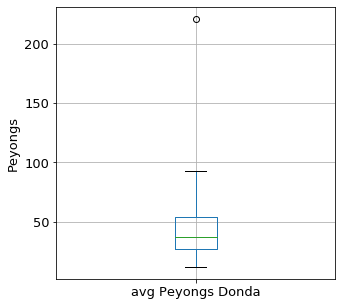

In [1064]:
temp_Donda = []
for song in Donda_Songs:
    temp_Donda.append(df_albums[song]["peyongs"].mean())

# print(pd.DataFrame({"avg Peyongs" : temp_Donda}, Donda_Songs))
avg_peyongs_Donda = pd.DataFrame({"avg Peyongs Donda" : temp_Donda}, Donda_Songs)
ax = avg_peyongs_Donda.boxplot(column = "avg Peyongs Donda", figsize=(5,5), fontsize=fontsize)
ax.set_ylim(avg_peyongs_Donda["avg Peyongs Donda"].min()-10, avg_peyongs_Donda["avg Peyongs Donda"].max()+10)
ax.set_ylabel("Peyongs", fontsize=fontsize);

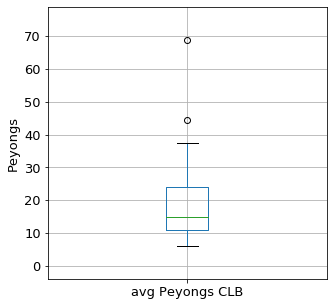

In [1066]:
temp_CLB = []
for song in CLB_Songs:
    temp_CLB.append(df_albums[song]["peyongs"].mean())

avg_peyongs_CLB = pd.DataFrame({"avg Peyongs CLB" : temp_CLB}, CLB_Songs)
# print(avg_peyongs_CLB)
ax = avg_peyongs_CLB.boxplot(column = "avg Peyongs CLB", figsize=(5,5), fontsize=fontsize)
ax.set_ylim(avg_peyongs_CLB["avg Peyongs CLB"].min()-10, avg_peyongs_CLB["avg Peyongs CLB"].max()+10)
ax.set_ylabel("Peyongs", fontsize=fontsize);

The box plots above show that Donda has a higher median peyongs conpared CLBs. this means that songs in donda are more liked and shared by genius users. the inter quartile range for both the graphs are very similar with upper quartile having more peyongs than the lower.

### Annotations
annotations is when a part of the lyrics is explained in the songs page. I will analyse this in the same way as the Peyongs by merging the data according to the albums and then plotting box plots of the number of annotations of each song. Below is the boxplot for Donda

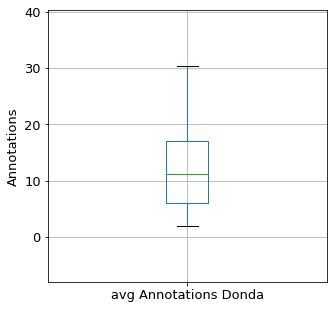

In [1067]:
temp_Donda_an = []
temp_CLB_an = []
for song in Donda_Songs:
    temp_Donda_an.append(df_albums[song]["Annotations"].mean())

# print(pd.DataFrame({"Annotations" : temp_Donda_an}, Donda_Songs))
avg_Annotations_Donda = pd.DataFrame({"avg Annotations Donda" : temp_Donda_an}, Donda_Songs)
ax = avg_Annotations_Donda.boxplot(column = "avg Annotations Donda", figsize=(5,5), fontsize=fontsize)
ax.set_ylim(avg_Annotations_Donda["avg Annotations Donda"].min()-10, avg_Annotations_Donda["avg Annotations Donda"].max()+10)
ax.set_ylabel("Annotations", fontsize=fontsize);


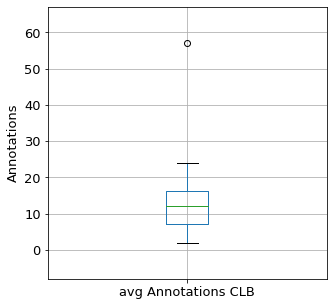

In [1068]:
temp_CLB_an = []
for song in CLB_Songs:
    temp_CLB_an.append(df_albums[song]["Annotations"].mean())

# print(pd.DataFrame({"Annotations" : temp_CLB_an}, CLB_Songs))
avg_Annotations_CLB = pd.DataFrame({"avg Annotations CLB" : temp_CLB_an}, CLB_Songs)
ax = avg_Annotations_CLB.boxplot(column = "avg Annotations CLB", figsize=(5,5), fontsize=fontsize)
ax.set_ylim(avg_Annotations_CLB["avg Annotations CLB"].min()-10, avg_Annotations_CLB["avg Annotations CLB"].max()+10)
ax.set_ylabel("Annotations", fontsize=fontsize);

The boxplots above show that the median number of box plots is approximately the same for both the albums. however the upper quartile and the upper whisker of Donda is longer compared to CLBs. this means even though they have the same median, Donda's songs have more annotations. 

### concurrents
comcurrents is the number of people that were on the song's page when the data was collected. To analyse this I decide to first merge the concurrent data according to the albums and then plotting a line graph of the sum of all the songs of each album. 

In [1075]:
df_temp_concurrents_CLB = merge_data_by_column("Concurrents", CLB_Songs)
df_temp_concurrents_Donda = merge_data_by_column("Concurrents", Donda_Songs)

df_temp_concurrents_CLB.head()

,Champagne poetry,Papi's home,Girls Want Girls,In The Bible,Love All,Fair Trade,Way 2 Sexy,TSU,N 2 Deep,Pipe Down,No Friends In The Industry,Knife Talk,7am On Bridle Path,Race My Mind,Fountains,Get Along Better,You Only Live Twice,IMY2,Fucking Fans,The Remorse
Key,,,,,,,,,,,,,,,,,,,,
1,5,0,2,2,2,5,6,4,2,3,3,2,0,0,3.0,2,2,2,0,0
2,3,3,6,3,0,7,4,2,3,3,2,5,2,0,0.0,0,0,0,2,2
3,0,2,4,0,0,9,0,2,2,0,2,3,2,0,0.0,0,2,2,2,0
4,0,2,0,3,0,5,0,2,2,0,2,2,0,0,0.0,0,0,0,0,3
5,2,3,2,3,0,3,3,0,0,2,2,3,3,2,2.0,0,2,0,0,2


the graph below shows total concurrents over key for Donda: 

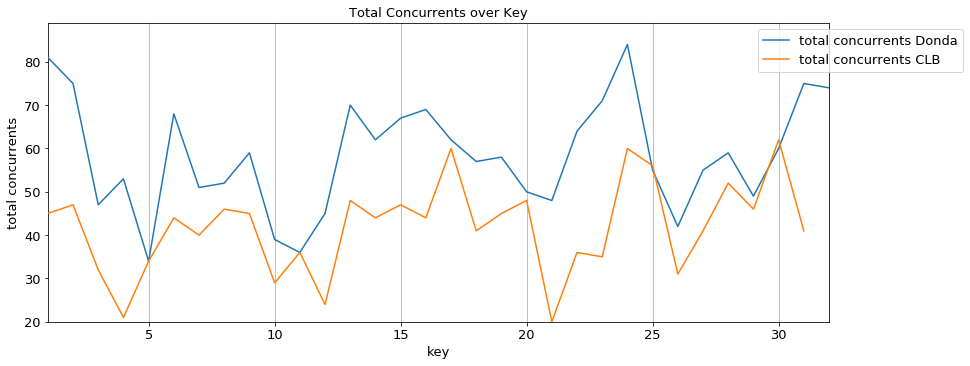

In [1078]:
sum_Donda = df_temp_concurrents_Donda.sum(axis = 1)
sum_CLB = df_temp_concurrents_CLB.sum(axis = 1)
df_sum_Donda = pd.DataFrame({"total concurrents Donda" : sum_Donda, "total concurrents CLB" : sum_CLB })
# print(df_sum_Donda)
ax = df_sum_Donda.plot(figsize=(14,5.5), fontsize=fontsize, zorder=3)
ax.set_title("Total Concurrents over Key", fontsize=fontsize)
ax.set_xlabel("key", fontsize=fontsize)
ax.set_ylabel("total concurrents", fontsize=fontsize)
# adjust the axis limits
ax.set_ylim(df_sum_Donda["total concurrents CLB"].min(), df_sum_Donda["total concurrents Donda"].max()+5)
ax.set_xlim(df_sum_Donda.index.min(), df_sum_Donda.index.max())
ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)
# add an x grid
ax.xaxis.grid(True);

by looking at this graph we can see that the total concurrents is most of the time higher for donda than CLB. This means that Donda songs are more active compared to CLBs. This also justifies the more page views for donda we look at above.  

### Correlation between the variables
Now we look at how different variables of the data are correlated. To do that i first stacked all of the DataFrames for the songs into a single DataFrame.  

In [851]:
import numpy as np
def plot_heatmap(title, df_in, figsize=(5.5, 5)):
    df_corr = df_in.corr()
    # create a color palettte
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # display the heatmap
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df_corr, square=True, cbar=False,
                annot=True, cmap=cmap, linewidths=0.5, vmin=-1)
    ax.set_title(title)

Below are the columns I selected to check for correlation.

In [852]:
target_columns = ["page_views", "peyongs", "Annotations", "Concurrents", "word Count"]

In [856]:
all_dfs = []
temp_songs = []
for song in all_Songs:
    all_dfs.append(df_albums[song].reset_index())
# concatendate all of the DataFrames into a single stacked frame
df_all = pd.concat(all_dfs)
# df_all["word Count"] = 
df_all.head()

,Key,Song,artist_name,page_views,peyongs,Annotations,Concurrents,word Count
0,1,Champagne poetry,Drake,624184,24,15,5,917
1,2,Champagne poetry,Drake,624296,24,15,3,917
2,3,Champagne poetry,Drake,624689,24,15,0,917
3,4,Champagne poetry,Drake,624705,24,15,0,917
4,5,Champagne poetry,Drake,624714,24,15,2,917


Filtering the full data for the target columns

In [858]:
df_all2 = df_all[target_columns]
df_all2.head()

,page_views,peyongs,Annotations,Concurrents,word Count
0,624184,24,15,5,917
1,624296,24,15,3,917
2,624689,24,15,0,917
3,624705,24,15,0,917
4,624714,24,15,2,917


Then to check the relationships I plotted a scatter matrix below:

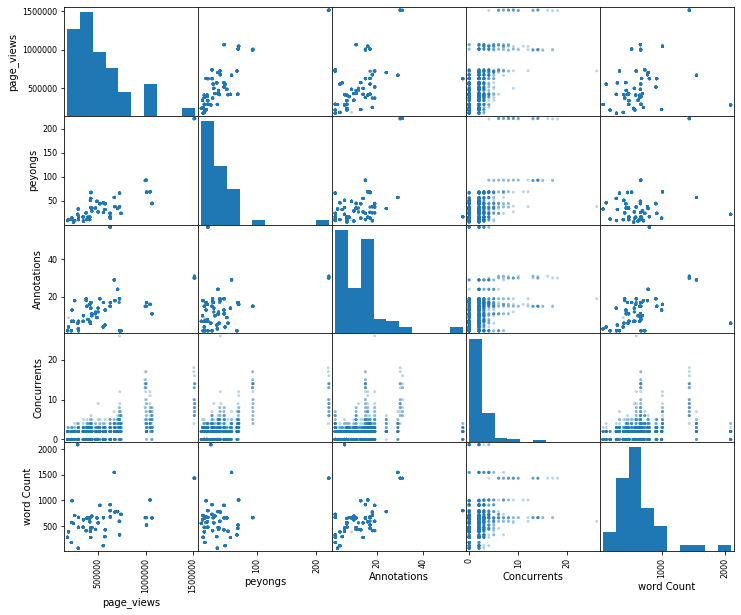

In [859]:
ax = scatter_matrix(df_all2, figsize=(12,10), alpha=0.3)

Scatter matrix is hard to read so I decided to plot a heat map aswell 

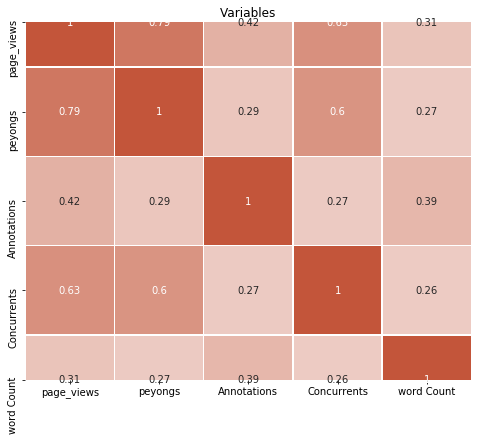

In [938]:
plot_heatmap("Variables", df_all2, figsize=(8,8))

looking at the heatmap we can see that there is a strong correlation between the peyongs and the page views. also the is partially strong relationship between concurrents and the page views. The other veriables have positive but very weak correlation 

## Conclusion 
In this assignment we analysed and compared data for 2 music albums CLB ans Donda. we focused on variable page views, peyongs, concurrents and etc. the outcome from this analysis is pretty clear that Donda is a more popular album according to the Genius data. 

working with Genius API was a but challenging as it did not provide enough variables to work with. This was the main reason i decided i will gather the data multiple times and analyse the songs through that period. 

If the API provided more data about the page views of each month or week, this analysis could have been much better and in depth.